![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [ ]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

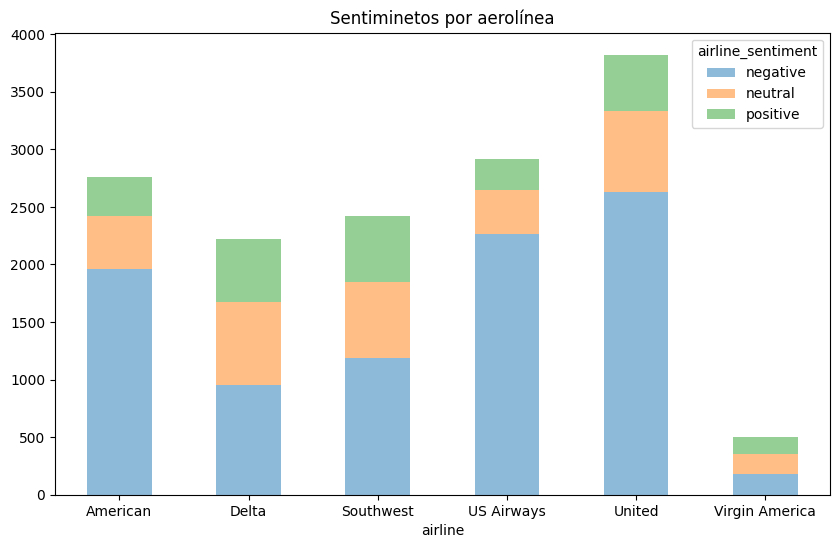

In [ ]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from nltk.corpus import stopwords

In [ ]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X

tweet_id
570306133677760513                  @VirginAmerica What @dhepburn said.
570301130888122368    @VirginAmerica plus you've added commercials t...
570301083672813571    @VirginAmerica I didn't today... Must mean I n...
570301031407624196    @VirginAmerica it's really aggressive to blast...
570300817074462722    @VirginAmerica and it's a really big bad thing...
                                            ...                        
569587686496825344    @AmericanAir thank you we got on a different f...
569587371693355008    @AmericanAir leaving over 20 minutes Late Flig...
569587242672398336    @AmericanAir Please bring American Airlines to...
569587188687634433    @AmericanAir you have my money, you change my ...
569587140490866689    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [ ]:
y

tweet_id
570306133677760513    0
570301130888122368    1
570301083672813571    0
570301031407624196   -1
570300817074462722   -1
                     ..
569587686496825344    1
569587371693355008   -1
569587242672398336    0
569587188687634433   -1
569587140490866689    0
Name: airline_sentiment, Length: 14640, dtype: int64

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
#Para comparar las métricas de cada modelo
Accuracy = {}

In [ ]:
# Celda 1

# Crear el objeto CountVectorizer y ajuste a los datos de entrenamiento
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transformar los datos de prueba con el vectorizador ajustado
X_test_vectorized = vectorizer.transform(X_test)

# Crear del modelo y entrenamiento

model_RF = RandomForestClassifier()
model_RF.fit(X_train_vectorized, y_train)

# Predicciones en el conjunto de prueba
y_pred = model_RF.predict(X_test_vectorized)

# Desempeño del modelo
accuracy = accuracy_score( y_test, y_pred)
print("Accuracy: ", accuracy)
Accuracy['Mod CountVect'] = accuracy

Accuracy:  0.7750413907284768


# Observaciones

- Como se puede observar en el resultado anterior con un modelo de random forest con un vectorizador de recuento (CountVectorizer) se tiene una precisión del 77,5% de que se prediga correctamente el sentimiento de los tweets.

- Consideramos que el desempeño no esta bueno, sin embargo con el desarrollo de los siguiente puntos se espera que la precisión mejore. 

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 2

# Crear un objeto CountVectorizer para convertir las palabras en vectores
vector_sin_stopwords = CountVectorizer(stop_words='english')

# Convertir los tweets de entrenamiento y test en matrices de términos de documentos
X_train_v = vector_sin_stopwords.fit_transform(X_train)
X_test_v = vector_sin_stopwords.transform(X_test)

# Crear un modelo de Random Forest y entrenarlo con los datos de entrenamiento, 100 estimadores
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_v, y_train)

# Predecir los sentimientos de los tweets de test
predicciones = rf.predict(X_test_v)

# Desempeño del modelo
accuracy_StopW = accuracy_score(y_test, predicciones)
print("Accuracy: ", accuracy_StopW)
Accuracy['Mod CountVect_StopWords'] = accuracy_StopW



Accuracy:  0.761796357615894


# Observaciones:
- El valor de 0.7618 es el resultado de la exactitud (accuracy) obtenida al aplicar el modelo de Random Forest con un vectorizador de recuento (CountVectorizer)al conjunto de datos de prueba después de haber utilizado la técnica de eliminación de palabras vacías o stop words

- Este valor indica que el modelo clasificó correctamente el 76.18% de los tweets del conjunto de prueba en términos de su sentimiento. Es decir, aproximadamente 3 de cada 4 tweets fueron clasificados correctamente

- Sin embargo podemos evidenciar que la eliminación de las stopwords no mejora el modelo.

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 3
# Importación de librerias
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# Descargar las stop words y lematizador de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_verbs(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = []
    for tag in pos_tags:
        if tag[1].startswith('V'):
            lemmatized_word = wordnet_lemmatizer.lemmatize(tag[0], nltk.corpus.wordnet.VERB)
        else:
            lemmatized_word = tag[0]
        lemmatized_words.append(lemmatized_word)
    return ' '.join(lemmatized_words)

# Crea un objeto CountVectorizer y lo utiliza para transformar el corpus de texto
vectorizer_lem = CountVectorizer(preprocessor=lemmatize_verbs)
X_train_counts = vectorizer_lem.fit_transform(X_train)
X_test_counts = vectorizer_lem.transform(X_test)

# Crea un modelo RandomForest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_counts, y_train)

# Predecir las etiquetas para los datos de prueba y evaluar la precisión del modelo
pred_st = rfc.predict(X_test_counts)

# Calcular el desempeño del modelo
accuracy_st = accuracy_score(y_test, pred_st)
print("Accuracy: ", accuracy_st)
Accuracy['Lematización con verbos'] = accuracy_st

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Accuracy:  0.7644867549668874


#Observaciones

- El modelo de clasificación RandomForest y un preprocesamiento de texto que se enfoca en la lematización de verbos. El preprocesador personalizado lemmatize_verbs lematiza solo los verbos en el texto, lo que puede ayudar a reducir la variabilidad en la representación de las palabras y mejorar la capacidad del modelo para generalizar a partir de los datos de entrenamiento.

- El modelo alcanza una precisión de 0.7645 (aproximadamente 76.45%) en los datos de prueba. Esto indica que el modelo RandomForest entrenado con lematización de verbos es capaz de predecir correctamente las etiquetas en un 76.45% de los casos en el conjunto de datos de prueba.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 4


# Descargar las stop words y lematizador de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

wordnet_lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_verbs(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = []
    for tag in pos_tags:
        if tag[1].startswith('V'):
            lemmatized_word = wordnet_lemmatizer.lemmatize(tag[0], nltk.corpus.wordnet.VERB)
        else:
            lemmatized_word = tag[0]
        lemmatized_words.append(lemmatized_word)
    return ' '.join(lemmatized_words)

# Crea un objeto CountVectorizer y lo utiliza para transformar el corpus de texto
vectorizer_lem = CountVectorizer(stop_words='english', preprocessor=lemmatize_verbs)
X_train_counts = vectorizer_lem.fit_transform(X_train)
X_test_counts = vectorizer_lem.transform(X_test)

# Crea un modelo RandomForest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_counts, y_train)

# Predecir las etiquetas para los datos de prueba y evaluar la precisión del modelo
predicciones_sw = rfc.predict(X_test_counts)

# Calcular el desempeño del modelo
accuracy_sin_sw = accuracy_score(y_test, predicciones_sw)
print("Accuracy: ", accuracy_sin_sw)
Accuracy['Mod Lematizacion-SW'] = accuracy_sin_sw

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Accuracy:  0.7622102649006622


#Observaciones:
- El modelo de clasificación RandomForest y un preprocesamiento de texto que se enfoca en la lematización de verbos y en la eliminación de las palabras vacías (stop words)

- El modelo alcanza una precisión de 0.7622 (aproximadamente 76.22%) en los datos de prueba. Esto indica que el modelo RandomForest entrenado con lematización de verbos y eliminación de stop words es capaz de predecir correctamente las etiquetas en un 76.22% de los casos en el conjunto de datos de prueba.



### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

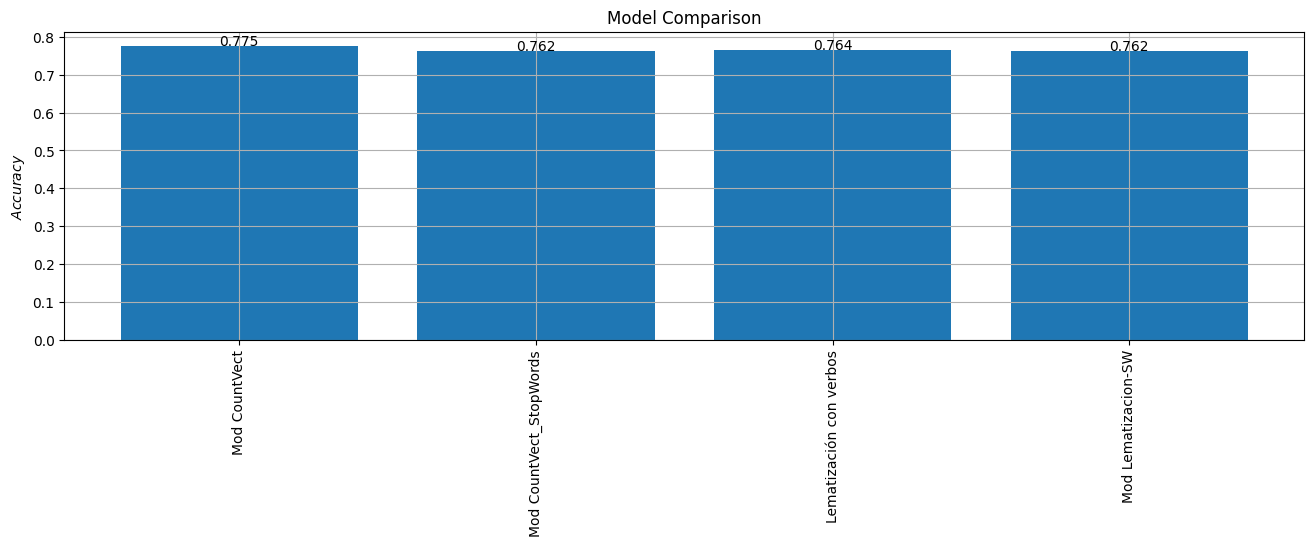

In [ ]:
# Celda 5
plt.figure(figsize=(16,4))
plt.bar(Accuracy.keys(),Accuracy.values() )
plt.ylabel('$Accuracy$')
plt.title('Model Comparison')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+ 0.002, round(y[i],3), ha = 'center')
        plt.xticks(rotation=90)

add_labels(Accuracy.keys(),list(Accuracy.values()))



Observaciones:

1. El primer algoritmo usando un modelo de random forest con un vectorizador de recuento (CountVectorizer) clasifico el 77.50% bien los tweets, de acuerdo a su accuracy. 

2. El segundo algoritmo usando un modelo de Random Forest con un vectorizador de recuento (CountVectorizer) incorpora la eiminación de stop words y a pesar de ello el accuracy no mejora y por el contrario disminuye ligeramente al 76.17%; de acuerdo al análisis exploratorio es probable que la eliminación de stop words pudieron borrar algunas palabras y afectar la predicción del modelo.

3. El tercer algoritmo usando RandomForest y un preprocesamiento de texto que se enfoca en la lematización de verbos, obtuvo un accuracy de 0.7644, sin presentar mejoras con respecto al primer algoritmo y sí ligeramente frente al segundo; esto puede ser explicado porque este tipo de modelos al reducir las palabras a su forma base tambien mejoran la predicción.

4. El último algoritmo empleado, RandomForest y un preprocesamiento de texto que se enfoca en la lematización de verbos y en la eliminación de las palabras vacías (stop words), no mostro el mejor desempeño al obtener un accuracy de 0.7622, a pesar que reducir las palabras a su forma base y eliminar stop words puede mejorar la predicción de los algoritmos.

De estos cuatro enfoques, el primer algoritmo, que empleó solo un vectorizador de recuento (CountVectorizer), tuvo el mejor desempeño en términos de precisión en la clasificación de los tweets. Los otros tres algoritmos no mostraron mejoras significativas con respecto al primero, a pesar de utilizar diferentes técnicas de preprocesamiento de texto
